In [2]:
import fsspec
import xarray as xr
import s3fs
import glob
import matplotlib.pyplot as plt
import copernicusmarine

In [3]:
url = 'gs://pilot-hubs-scratch-ohw/miost/science'
fs, path = fsspec.url_to_fs(url)

In [4]:
fs.ls(path)

['pilot-hubs-scratch-ohw/miost/science/',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230710_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230711_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230712_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230713_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230714_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230715_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230716_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230717_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230718_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230719_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230720_20240501.nc',
 'pilot-hubs

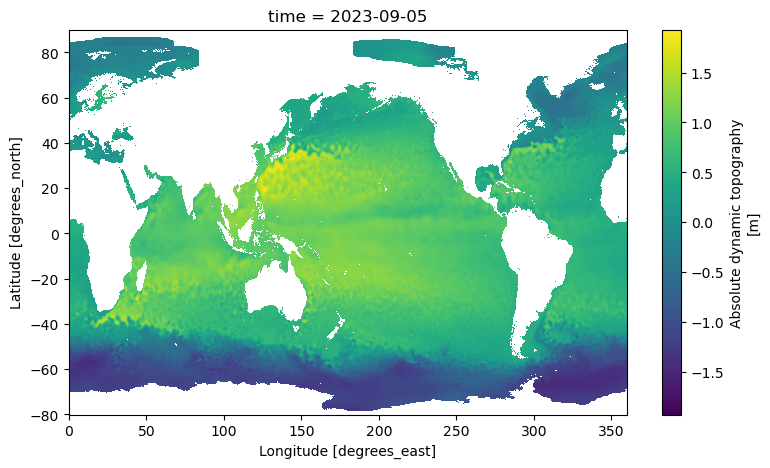

In [5]:
plt.figure(figsize=(9,5))

with fs.open('pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230905_20240501.nc') as file:
    ds = xr.open_dataset(file, engine='h5netcdf')
    ds['adt'].plot(cmap='viridis')

In [6]:
opened_files = []
for path in fs.ls(path):
    if '.nc' and '202308' in path:
        opened_files.append(fs.open(path))
mds = xr.open_mfdataset(opened_files)

In [7]:
mds = mds.sel(
    longitude=slice(13,17),
    latitude=slice(-40,-36),
)

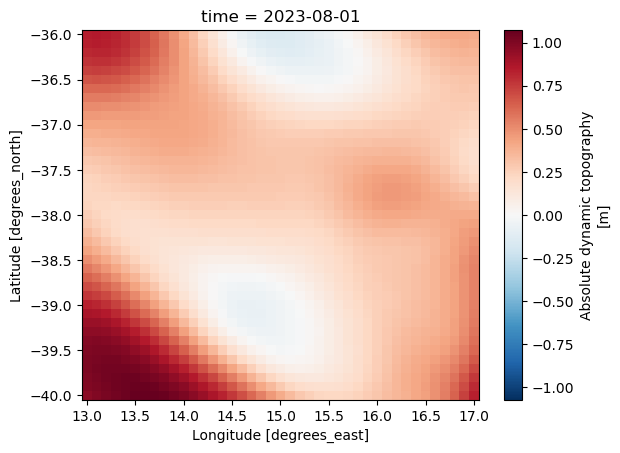

In [8]:
mds.isel(time=0)['adt'].plot()

In [9]:
mds_rolling = mds.rolling(latitude=3, longitude=3, center=True).mean()

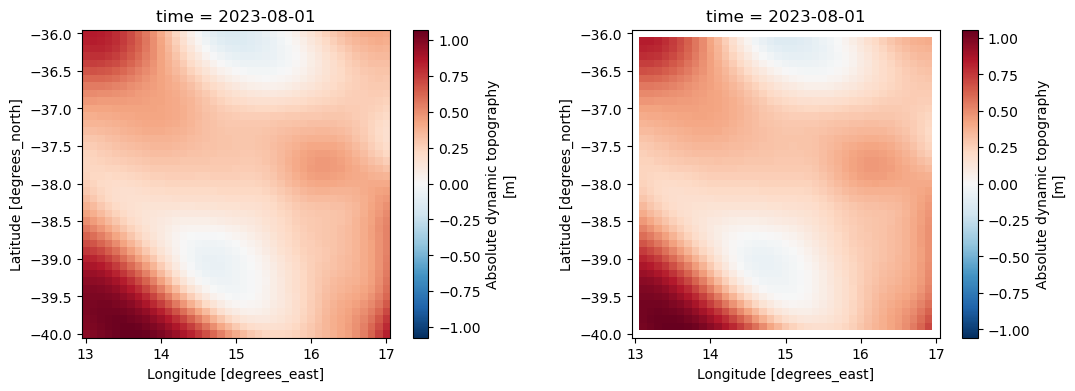

In [15]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(13,4),
)

ax1.set_aspect('equal')
mds.isel(time=0)['adt'].plot(ax=ax1)

ax2.set_aspect('equal')
mds_rolling.isel(time=0)['adt'].plot(ax=ax2)

In [16]:
def copernicus(ID,lon,lat,time,var,username='pwalfir',password='PedroW100%'):
        # Set parameters
    data_request = {
       "dataset" : ID,
       "longitude" : lon, 
       "latitude" : lat,
       "time" : time,
       "variables" : var
    }

    # Load xarray dataset
    dat = copernicusmarine.open_dataset(
        dataset_id = data_request["dataset"],
        minimum_longitude = data_request["longitude"][0],
        maximum_longitude = data_request["longitude"][1],
        minimum_latitude = data_request["latitude"][0],
        maximum_latitude = data_request["latitude"][1],
        start_datetime = data_request["time"][0],
        end_datetime = data_request["time"][1],
        variables = data_request["variables"],
        username  = username,
        password = password
    )
    return dat

In [17]:
dat_aviso = copernicus("cmems_obs-sl_glo_phy-ssh_myint_allsat-l4-duacs-0.25deg_P1D",
                       [13,17],
                       [-40,-36],
                       ["2023-08-01", "2023-08-31"],
                       ["adt"])

INFO - 2024-08-30T03:00:37Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-30T03:00:37Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-30T03:00:40Z - Service was not specified, the default one was selected: "arco-time-series"


In [20]:
mds_interp = mds_rolling.interp_like(dat_aviso)

In [38]:
residuo = mds_interp.isel(time=0)['adt'] - dat_aviso.isel(time=0)['adt']

Text(0, 0.5, '')

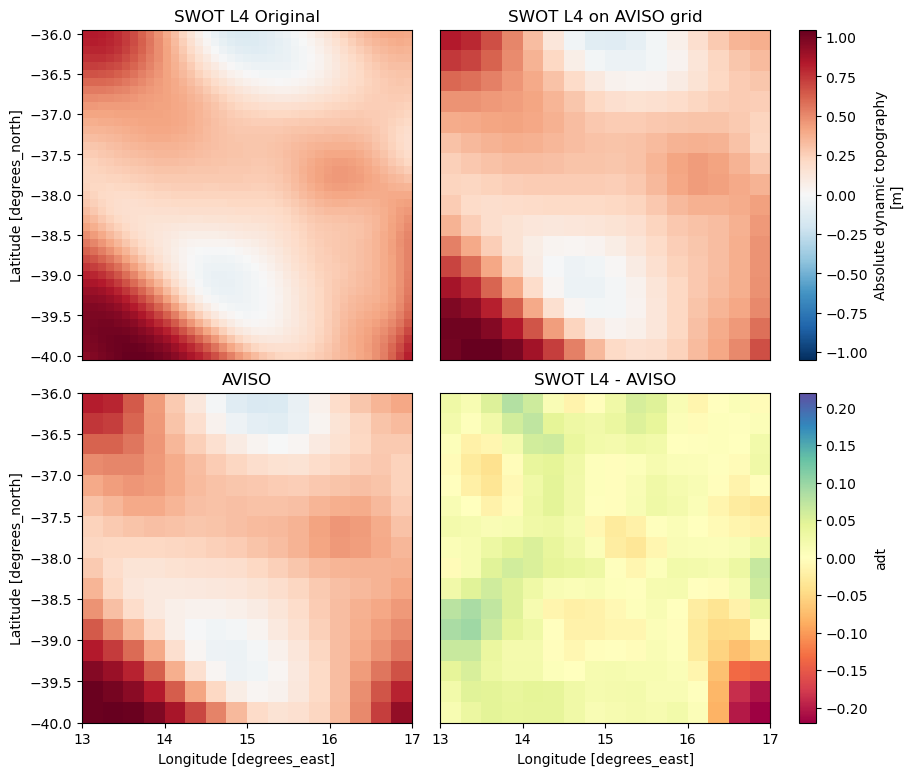

In [85]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12,9),
)

fig.subplots_adjust(hspace=.1, wspace=-.4)

ax1.set_aspect('equal')
mds.isel(time=0)['adt'].plot(ax=ax1, add_colorbar=False)
ax1.set_title('SWOT L4 Original')
ax1.set_xticks([])
ax1.set_xlabel('')

ax2.set_aspect('equal')
mds_interp.isel(time=0)['adt'].plot(ax=ax2)
ax2.set_title('SWOT L4 on AVISO grid')
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_ylabel('')

ax3.set_aspect('equal')
dat_aviso.isel(time=0)['adt'].plot(ax=ax3, add_colorbar=False)
ax3.set_title('AVISO')

ax4.set_aspect('equal')
residuo.plot(ax=ax4, cmap='Spectral', label='Absolute dynamical topography residue [m]')
ax4.set_title('SWOT L4 - AVISO')
ax4.set_yticks([])
ax4.set_ylabel('')